In [1]:
import sys
import os

# Add the parent directory to the sys.path to avoid 'ModuleNotFoundError'
sys.path.append(os.path.abspath(os.path.join('..')))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

# Set default font to sans-serif
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

from src.preprocessing import *
from src.visualization import *
from src.trainer import *
from src.config import *
from src.helpers import *
from src.paths import paths

In [2]:
# Get lists of data by folds
X_train_list = [pd.read_csv(path) for path in paths.get('X_train_paths')]
y_train_list = [pd.read_csv(path) for path in paths.get('y_train_paths')]
y_train_list = [y_train[TARGET].to_numpy() for y_train in y_train_list]

X_val_list   = [pd.read_csv(path) for path in paths.get('X_val_paths')]
y_val_list   = [pd.read_csv(path) for path in paths.get('y_val_paths')]
y_val_list   = [y_val[TARGET].to_numpy() for y_val in y_val_list]

y_val_full = []
for y_val_fold in y_val_list:
    y_val_full.extend(y_val_fold)
assert len(y_val_full) == 273

n_folds = 5

In [3]:
# Get metrics for all models accross all folds
pred_dict = {}
pred_proba_dict = {}
metric_dict = {} # metrics for each model on all folds
metric_fold_dict = {} # metrics for each model on each fold

for model_name in MODEL_NAMES:
    pred_list = []
    pred_proba_list = []
    metric_list = []

    for fold in range(n_folds):
        # Load data for the current fold
        X_train, y_train, X_val, y_val = load_data_fold(fold)

        # Load trained model for the current fold
        model = load_model_fold(fold, model_name=model_name)

        # Get predictions for the current fold
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:,-1]

        pred_list.extend(y_pred)
        pred_proba_list.extend(y_pred_proba)

        metric_fold = calculate_metrics(y_val, y_pred, y_pred_proba)
        metric_list.append(metric_fold)
    
    # Save predictions for this model
    pred_dict[model_name] = [float(x) for x in pred_list]
    pred_proba_dict[model_name] = [float(x) for x in pred_proba_list]

    # Save metrics for this model
    metric_dict[model_name] = calculate_metrics(y_val_full, pred_list, pred_proba_list)
    metric_fold_dict[model_name] = metric_list

In [4]:
save_json(paths.get('metric_fold_path'), metric_fold_dict)
save_json(paths.get('metric_path'), metric_dict)
save_json(paths.get('pred_path'), pred_dict)
save_json(paths.get('pred_proba_path'), pred_proba_dict)

## Table 2. Evaluation Metrics for Six Machine Learning Models Across Five Folds

In [5]:
metric_df = pd.DataFrame(metric_dict).T
metric_df = round(metric_df, 4)
metric_df.drop(columns='mse', inplace=True)
metric_df.columns = ['ACC', 'AUC', 'F1 Score', 'Precision', 'Recall', 'Specificity']
metric_df

,ACC,AUC,F1 Score,Precision,Recall,Specificity
catboost,0.8791,0.9312,0.8675,0.8710,0.864,0.8919
xgboost,0.8645,0.9202,0.8514,0.8548,0.848,0.8784
lgbm,0.8791,0.9150,0.8675,0.8710,0.864,0.8919
rf,0.8388,0.9097,0.8295,0.8045,0.856,0.8243
svm,0.8168,0.8985,0.8031,0.7907,0.816,0.8176
lr,0.8132,0.8922,0.7935,0.8033,0.784,0.8378


## Figure 5. Heatmap of normalized SHAP values of features of six ML models.

In [6]:
# Get top 5 SHAP feature importance for each model
scaler = MinMaxScaler()
fi_list = []

for model_name in MODEL_NAMES:
    # Get model's SHAP feature importance sroted by Feature name alphabetically
    fi = pd.read_csv(paths[model_name]['shap_fi'])\
            .sort_values('Feature')\
            .rename(columns={'Importance': model_name})\
            .set_index('Feature')
            
    # Normalize feature importance values
    fi_normalized = pd.DataFrame(scaler.fit_transform(fi), columns=fi.columns).set_index(fi.index)
    fi_list.append(fi_normalized)

fi_df = pd.concat(fi_list, axis=1)
fi_df.columns = [['CatBoost', 'XGBoost', 'LGBM', 'RF', 'SVM', 'LR']]

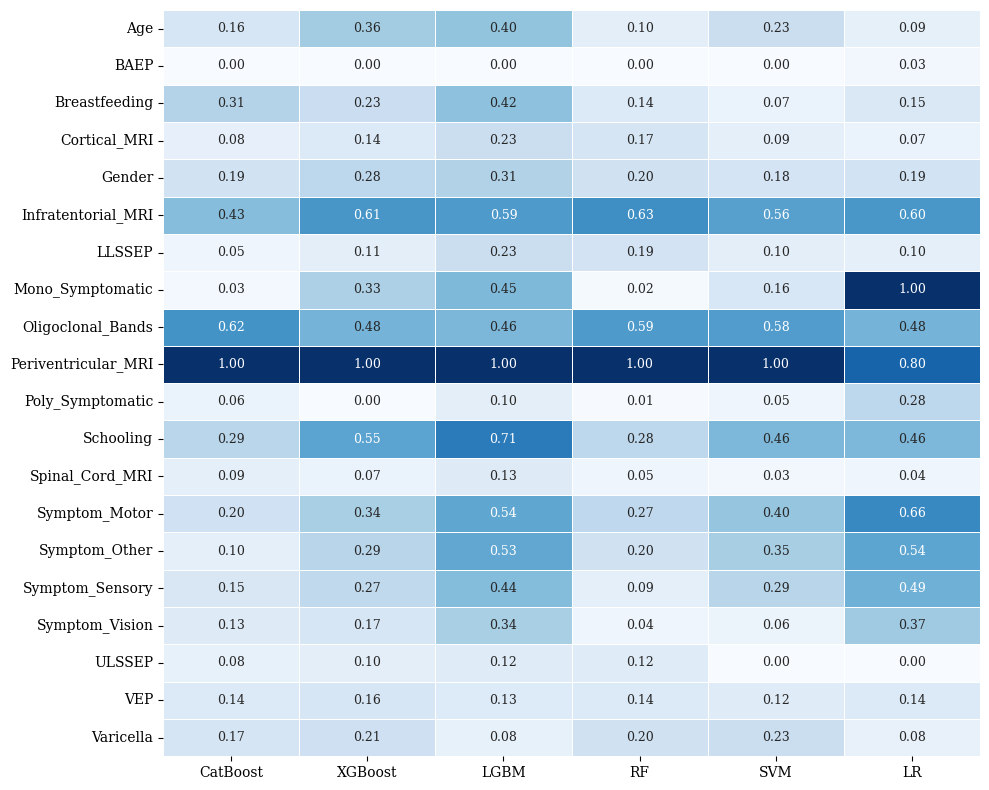

In [7]:
# Plot the heatmap
plt.figure(figsize=(10,8))
sns.heatmap(fi_df, 
            annot=True, 
            cmap='Blues', 
            linewidths=0.5, 
            cbar=False, 
            annot_kws={"fontsize": 9},
            fmt=".2f")  # Format annotations to 2 decimal places

plt.ylabel('')
plt.xlabel('')
plt.tight_layout()
#plt.savefig('../img/fig5.jpeg', format='jpeg', dpi=720)